# Part 1A: Johnson & Johnson – ARIMA Forecast

In [2]:
!pip install pmdarima

  Obtaining dependency information for pmdarima from https://files.pythonhosted.org/packages/ac/f8/6c9364602b13f0dba129b53acd1344859690911a4d5021560d9fd6aa087f/pmdarima-2.0.4-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for Cython!=0.29.18,!=0.29.31,>=0.29 from https://files.pythonhosted.org/packages/02/4e/5ac0b5b9a239cd3fdae187dda8ff06b0b812f671e2501bf253712278f0ac/Cython-3.0.12-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/614.7 kB ? eta -:--:--
   - ------------------------------------- 20.5/614.7 kB 640.0 kB/s eta 0:00:01
   --- ----------------------------------- 51.2/614.7 kB 525.1 kB/s eta 0:00:02
   ------ ------------------------------- 102.4/614.7 kB 590.8 kB/s eta 0:00:01
   -------- ----------------------------- 133.1/614.7 kB 605.3 kB/s eta 0:00:01
   ---------- --------------------------- 163.8/614.7 kB 614.4 kB/s eta 0:00:01
   ------------ ------------------------- 204.8/614.7 kB 692.4 kB/s eta 0:00:01
   ---

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tables 3.8.0 requires blosc2~=2.0.0, which is not installed.


In [20]:
# === Setup ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

In [62]:
# === Load JJ Data ===
jj = pd.read_csv("jj.csv")

In [63]:
jj.head()

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


In [64]:
jj['date'] = pd.to_datetime(jj['date'], dayfirst=True)
jj.set_index('date', inplace=True)
jj = jj[['data']].astype(float)
jj.head()

,data
date,
1960-01-01,0.71
1960-01-04,0.63
1960-02-07,0.85
1960-01-10,0.44
1961-01-01,0.61


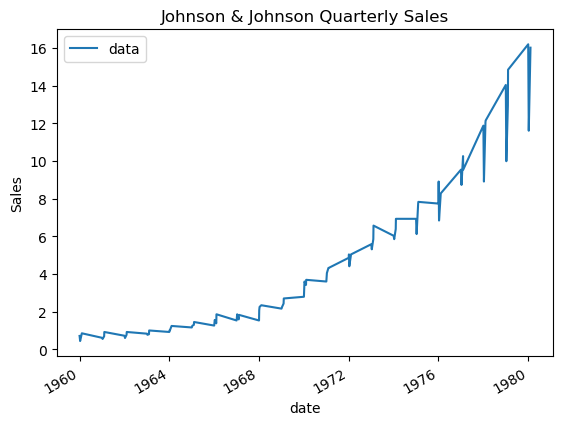

In [65]:
# === Plot the original data ===
jj.plot(title='Johnson & Johnson Quarterly Sales')
plt.ylabel("Sales")
plt.show()

In [66]:
# === ADF Test for Stationarity ===
result = adfuller(jj['data'].dropna())
print(f"ADF Statistic: {result[0]}, p-value: {result[1]}")

ADF Statistic: 2.7420165734574673, p-value: 1.0


In [67]:
# === Make Data Stationary ===
jj_log = np.log(jj['data'])
jj_diff = jj_log.diff().dropna()

In [68]:
# Recheck ADF
result2 = adfuller(jj_diff)
print(f"ADF after log-diff: {result2[0]}, p-value: {result2[1]}")

ADF after log-diff: -4.317043945811824, p-value: 0.00041497314044408725


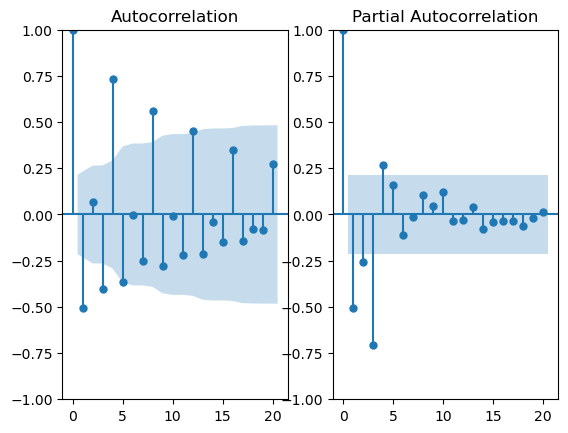

In [17]:
# === Plot ACF and PACF ===
fig, axes = plt.subplots(1, 2)
plot_acf(jj_diff, lags=20, ax=axes[0])
plot_pacf(jj_diff, lags=20, ax=axes[1])
plt.show()

In [18]:
# === Find Best ARIMA Parameters ===
model_auto = pm.auto_arima(jj['data'], seasonal=False, d=1,
                           max_p=8, max_q=8,
                           trace=True, stepwise=True)
print(model_auto.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=240.020, Time=3.75 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=297.285, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=264.953, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=255.333, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=295.995, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=238.454, Time=0.97 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=229.503, Time=0.65 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=259.465, Time=1.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=251.412, Time=0.49 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=228.486, Time=2.63 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=4.67 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=4.09 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=6.54 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=4.60 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=inf, Time=3.00 sec

B

In [21]:
# === Fit Model ===
model = ARIMA(jj['data'], order=model_auto.order)
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   data   No. Observations:                   84
Model:                 ARIMA(1, 1, 3)   Log Likelihood                -114.048
Date:                Wed, 09 Apr 2025   AIC                            238.096
Time:                        16:47:43   BIC                            250.190
Sample:                             0   HQIC                           242.954
                                 - 84                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9869      0.140     -7.046      0.000      -1.261      -0.712
ma.L1         -0.4555      0.337     -1.352      0.176      -1.116       0.205
ma.L2         -0.3056      0.312     -0.978      0.3

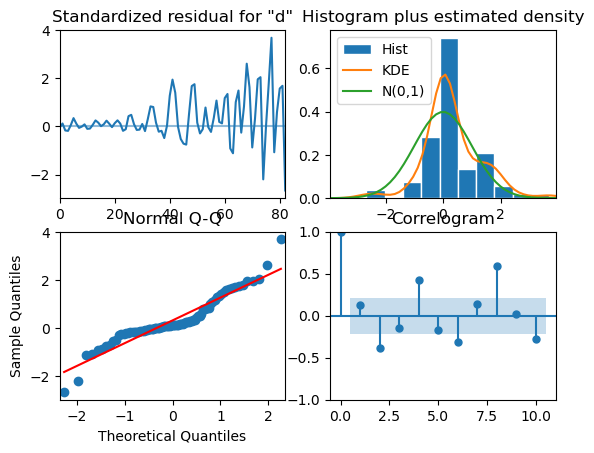

In [25]:
model_fit.plot_diagnostics()
plt.show()

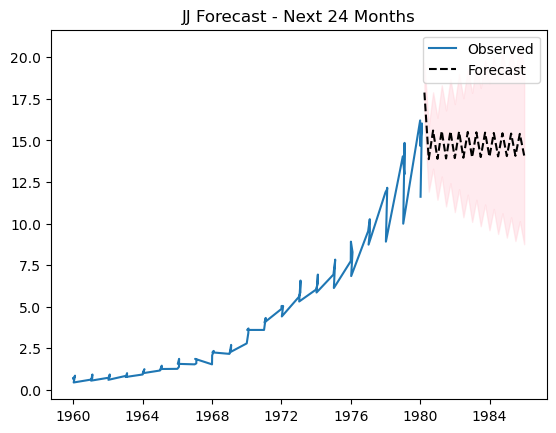

In [26]:
# === Forecast for 24 Months ===
forecast = model_fit.get_forecast(steps=24)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()
future_idx = pd.date_range(start=jj.index[-1] + pd.offsets.QuarterEnd(),
                           periods=24, freq='Q')
# === Plot Forecast ===
plt.plot(jj['data'], label='Observed')
plt.plot(future_idx, forecast_mean, 'k--', label='Forecast')
plt.fill_between(future_idx, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.title("JJ Forecast - Next 24 Months")
plt.legend()
plt.show()

In [27]:
# Part 1B: Amazon Stock – ARIMA Forecast

In [40]:
# === Load Amazon Data ===
amzn = pd.read_csv("AMZN.csv")

In [41]:
amzn['Date'] = pd.to_datetime(amzn['Date'], dayfirst=True)
amzn.set_index('Date', inplace=True)
amzn.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-02-20,72.324501,74.438499,72.324501,73.417503,73.417503,129984000
2018-02-21,74.250000,75.174500,73.945999,74.146004,74.146004,126088000
2018-02-22,74.767998,75.126999,73.788002,74.266998,74.266998,97162000
2018-02-23,74.766998,75.000000,74.324997,75.000000,75.000000,88362000
2018-02-26,75.459999,76.141998,75.349998,76.097504,76.097504,99100000


In [42]:
amzn = amzn['Close'].resample('M').mean().dropna().to_frame(name='Close')
amzn.head()

,Close
Date,
2018-02-28,74.878501
2018-03-31,77.018381
2018-04-30,73.411023
2018-05-31,79.745182
2018-06-30,84.941190


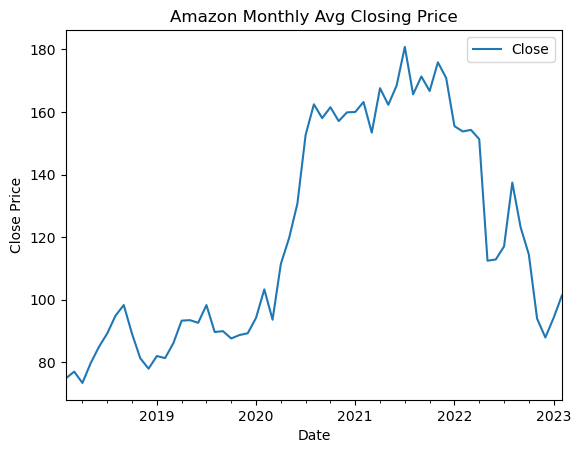

In [43]:
# === Plot ===
amzn.plot(title='Amazon Monthly Avg Closing Price')
plt.ylabel("Close Price")
plt.show()

In [44]:
# === Stationarity Test ===
adf_amzn = adfuller(amzn)
print(f"ADF Statistic: {adf_amzn[0]}, p-value: {adf_amzn[1]}")

ADF Statistic: -1.4203009804386064, p-value: 0.5725058112187189


In [45]:
# === Make Stationary ===
amzn_log = np.log(amzn['Close'])
amzn_log_diff = amzn_log.diff().dropna()

In [46]:
# Recheck ADF
result = adfuller(amzn_log_diff)
print(f"ADF Statistic: {result[0]}, p-value: {result[1]}")

ADF Statistic: -6.742352011752768, p-value: 3.095862492338449e-09


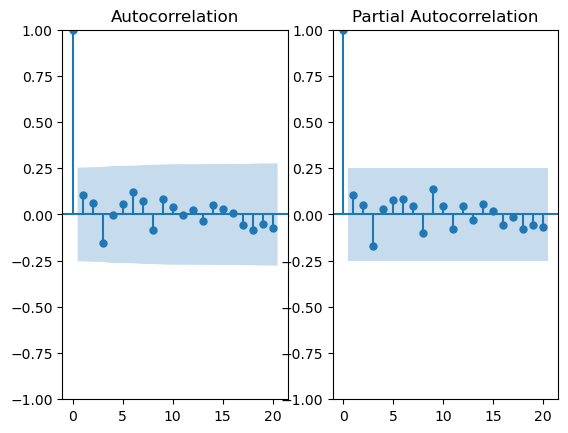

In [47]:
# === Plot ACF/PACF ===
fig, axes = plt.subplots(1, 2)
plot_acf(amzn_diff, lags=20, ax=axes[0])
plot_pacf(amzn_diff, lags=20, ax=axes[1])
plt.show()

In [50]:
# === Find ARIMA Parameters ===
model_amzn_auto = pm.auto_arima(amzn, seasonal=False, d=1,
                                 max_p=8, max_q=8,
                                 trace=True, stepwise=True)
print(model_amzn_auto.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.94 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=448.342, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=450.159, Time=0.41 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=450.182, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=446.463, Time=0.39 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=452.279, Time=1.90 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 4.179 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   61
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -222.232
Date:                Wed, 09 Apr 2025   AIC                            446.463
Time:                        16:57:07   BIC                            448.557
Sample:                    02-28-2018   HQIC                           447.282
                    

In [51]:
# === Fit and Forecast ===
model_amzn = ARIMA(amzn, order=model_amzn_auto.order)
amzn_fit = model_amzn.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   data   No. Observations:                   84
Model:                 ARIMA(1, 1, 3)   Log Likelihood                -114.048
Date:                Wed, 09 Apr 2025   AIC                            238.096
Time:                        16:57:29   BIC                            250.190
Sample:                             0   HQIC                           242.954
                                 - 84                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9869      0.140     -7.046      0.000      -1.261      -0.712
ma.L1         -0.4555      0.337     -1.352      0.176      -1.116       0.205
ma.L2         -0.3056      0.312     -0.978      0.3

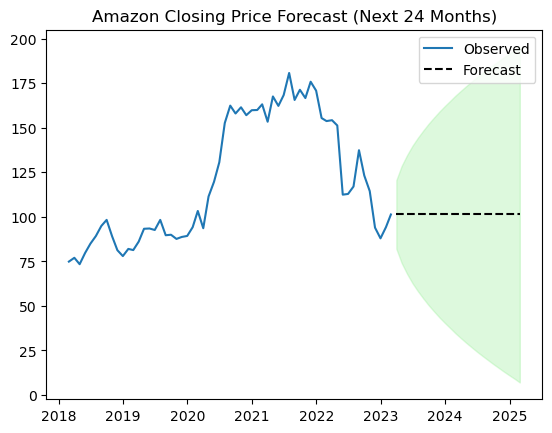

In [52]:
# === Plot ===
amzn_forecast = amzn_fit.get_forecast(steps=24)
amzn_mean = amzn_forecast.predicted_mean
amzn_ci = amzn_forecast.conf_int()
future_idx_amzn = pd.date_range(start=amzn.index[-1] + pd.offsets.MonthEnd(), periods=24, freq='M')
plt.plot(amzn, label='Observed')
plt.plot(future_idx_amzn, amzn_mean, 'k--', label='Forecast')
plt.fill_between(future_idx_amzn, amzn_ci.iloc[:, 0], amzn_ci.iloc[:, 1], color='lightgreen', alpha=0.3)
plt.title("Amazon Closing Price Forecast (Next 24 Months)")
plt.legend()
plt.show()

# Deep Learning RNN (LSTM) for Forecasting for johnson & johnson

In [74]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [101]:
jj_vals = jj['data'].values.reshape(-1, 1)

In [102]:
# === Normalize ===
scaler = MinMaxScaler()
jj_scaled = scaler.fit_transform(jj_vals)

In [103]:
# === Function to prepare sequence data ===
def prepare_data(series, n_steps=12):
    X, y = [], []
    for i in range(n_steps, len(series)):
        X.append(series[i - n_steps:i])
        y.append(series[i])
    return np.array(X), np.array(y)
# === Train-Test Split ===
n_forecast = 24
train_scaled = jj_scaled[:-n_forecast]
test_scaled = jj_scaled[-(n_forecast + 12):]  # Add 12 for sequence continuity
X_train, y_train = prepare_data(train_scaled)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test, y_test = prepare_data(test_scaled)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [104]:
# === Build LSTM Model ===
model_lstm = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, verbose=0)

In [105]:
# === Predict on Test Set ===
pred_scaled = model_lstm.predict(X_test)
y_pred = scaler.inverse_transform(pred_scaled)
y_true = scaler.inverse_transform(y_test)
# === Evaluation Metrics ===
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)
print("Evaluation Metrics (Last 24 Quarters):")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

1/1 [==============================] - 2s 2s/step
Evaluation Metrics (Last 24 Quarters):
MAE: 1.7042
MSE: 3.9405
RMSE: 1.9851
R² Score: 0.5475


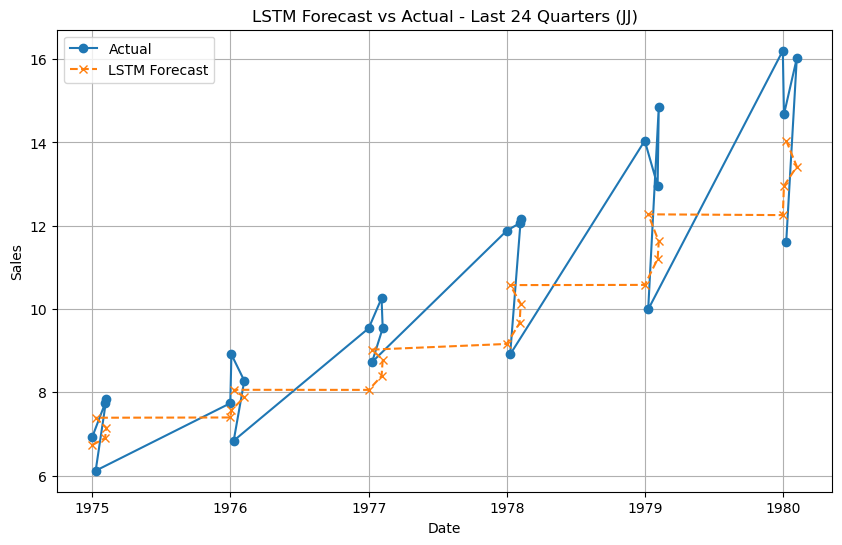

In [106]:
# === Plot Actual vs Predicted ===
plt.figure(figsize=(10, 6))
plt.plot(jj.index[-24:], y_true, label='Actual', marker='o')
plt.plot(jj.index[-24:], y_pred, label='LSTM Forecast', linestyle='--', marker='x')
plt.title('LSTM Forecast vs Actual - Last 24 Quarters (JJ)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

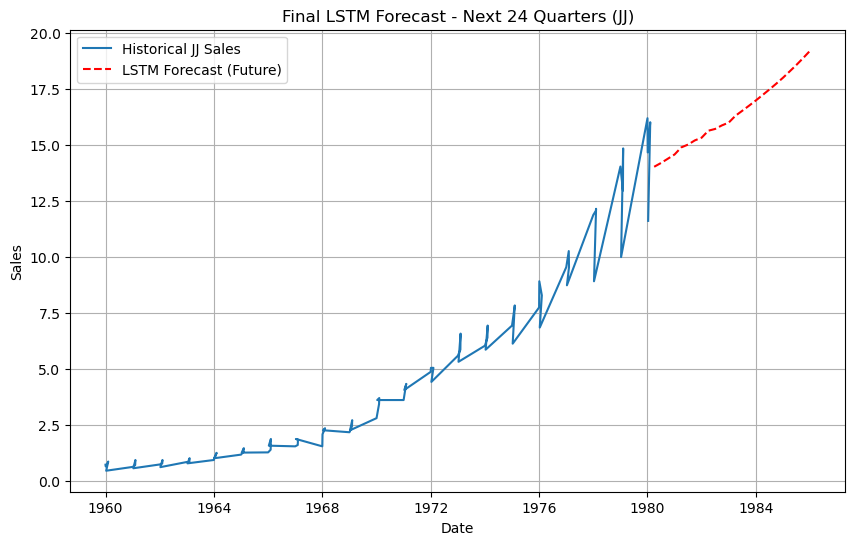

In [107]:
# === Final Forecast for Next 24 Quarters (Real Task) ===
last_seq = jj_scaled[-12:]
forecast_seq = []
for _ in range(24):
    input_seq = last_seq.reshape((1, 12, 1))
    pred = model_lstm.predict(input_seq, verbose=0)
    forecast_seq.append(pred[0, 0])
    last_seq = np.append(last_seq[1:], pred)

forecast_lstm = scaler.inverse_transform(np.array(forecast_seq).reshape(-1, 1))
forecast_dates = pd.date_range(start=jj.index[-1] + pd.offsets.QuarterEnd(), periods=24, freq='Q')
# === Plot Final 24 Quarters Forecast ===
plt.figure(figsize=(10, 6))
plt.plot(jj.index, jj['data'], label='Historical JJ Sales')
plt.plot(forecast_dates, forecast_lstm, 'r--', label='LSTM Forecast (Future)')
plt.title("Final LSTM Forecast - Next 24 Quarters (JJ)")
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

# Deep Learning RNN (LSTM) for Forecasting for Amazon

In [91]:
amzn_vals = amzn['Close'].values.reshape(-1, 1)
# === Normalize ===
scaler = MinMaxScaler()
amzn_scaled = scaler.fit_transform(amzn_vals)

In [92]:
# === Sequence prep function ===
def prepare_data(series, n_steps=12):
    X, y = [], []
    for i in range(n_steps, len(series)):
        X.append(series[i - n_steps:i])
        y.append(series[i])
    return np.array(X), np.array(y)
# === Train-Test Split ===
n_forecast = 24
train_scaled = amzn_scaled[:-n_forecast]
test_scaled = amzn_scaled[-(n_forecast + 12):]  # Include 12 for sequence
X_train, y_train = prepare_data(train_scaled)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test, y_test = prepare_data(test_scaled)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [97]:
# === LSTM Model ===
model_lstm = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, verbose=0)

In [98]:
# === Predict and Evaluate ===
pred_scaled = model_lstm.predict(X_test)
y_pred = scaler.inverse_transform(pred_scaled)
y_true = scaler.inverse_transform(y_test)
# === Evaluation Metrics ===
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)
print("Evaluation Metrics (Last 24 Months - AMZN):")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

1/1 [==============================] - 1s 1s/step
Evaluation Metrics (Last 24 Months - AMZN):
MAE: 14.0191
MSE: 275.8696
RMSE: 16.6093
R² Score: 0.6787


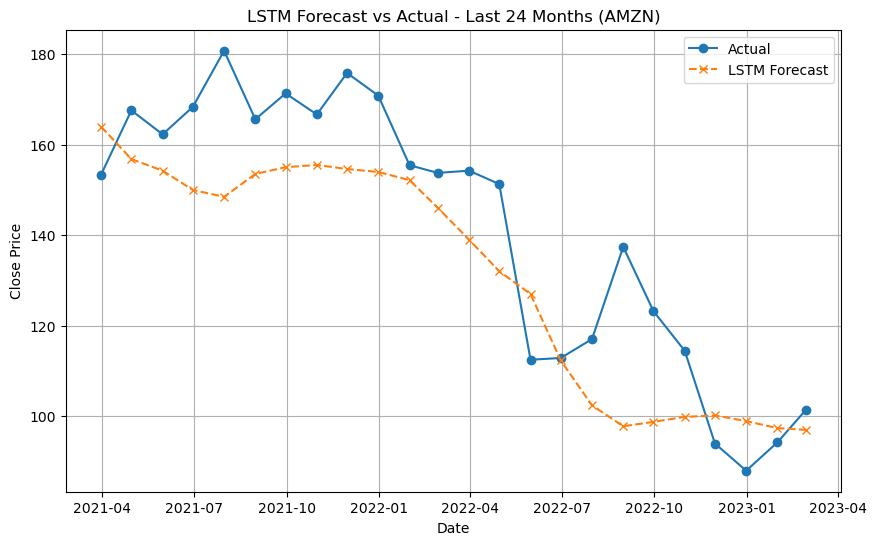

In [99]:
# === Plot Actual vs Predicted ===
plt.figure(figsize=(10, 6))
plt.plot(amzn.index[-24:], y_true, label='Actual', marker='o')
plt.plot(amzn.index[-24:], y_pred, label='LSTM Forecast', linestyle='--', marker='x')
plt.title('LSTM Forecast vs Actual - Last 24 Months (AMZN)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

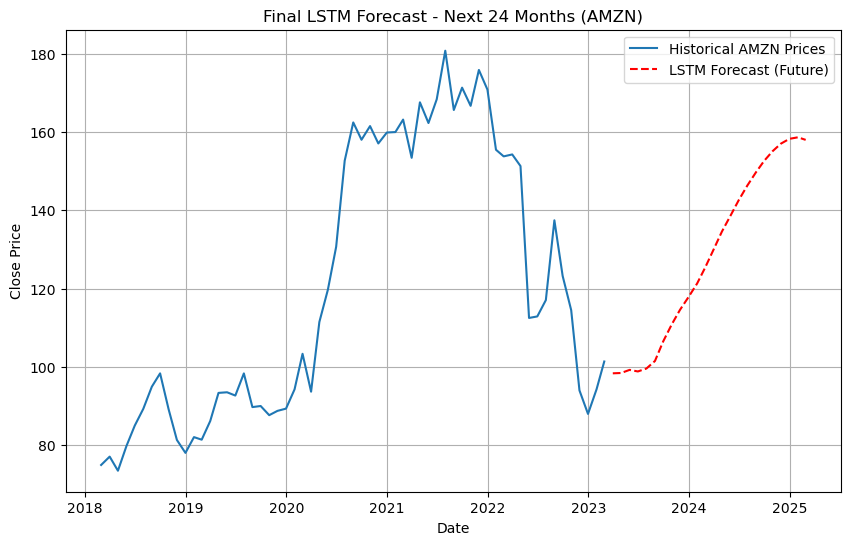

In [100]:
# === Final Forecast (Future 24 Months) ===
last_seq = amzn_scaled[-12:]
forecast_seq = []
for _ in range(24):
    input_seq = last_seq.reshape((1, 12, 1))
    pred = model_lstm.predict(input_seq, verbose=0)
    forecast_seq.append(pred[0, 0])
    last_seq = np.append(last_seq[1:], pred)

forecast_amzn = scaler.inverse_transform(np.array(forecast_seq).reshape(-1, 1))
forecast_dates = pd.date_range(start=amzn.index[-1] + pd.offsets.MonthEnd(), periods=24, freq='M')

# === Plot Future Forecast ===
plt.figure(figsize=(10, 6))
plt.plot(amzn.index, amzn['Close'], label='Historical AMZN Prices')
plt.plot(forecast_dates, forecast_amzn, 'r--', label='LSTM Forecast (Future)')
plt.title("Final LSTM Forecast - Next 24 Months (AMZN)")
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()